### Instructions
- Write a very simple segmentation algorithm that takes in a raw image and outputs a segmentation mask. We don't really care about the accuracy of the segmentation algorithm you write. Feel free to use something like color thresholding with hardcoded values to make the job easier.

- Choose two metrics we can use to measure the accuracy of your segmentation algorithm and explain why you select them and the tradeoffs you made selecting them within a README.

- Write two functions, one for each metric, that takes in a raw image along with the corresponding mask, computes the desired metric and returns them such that they can be utilized in a matplotlib graph.

In [1]:
from PIL import Image, ImageOps
from IPython import display

import numpy as np
import skimage.filters

import matplotlib.pyplot as mp
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D

import tqdm

In [2]:
# gif obtained from `https://www.vistapathbio.com`, contains 152 660×667 frames
detection_example_gif = 'data/crop+from+2019-03-14+17-18-03.gif'

# coordinates of tray portion of the image:
top_left, bot_right = [42, 158], [279, 445]

In [3]:
img = Image.open(detection_example_gif)
img.size

(660, 667)

In [4]:
n_frames = img.n_frames
n_frames

152

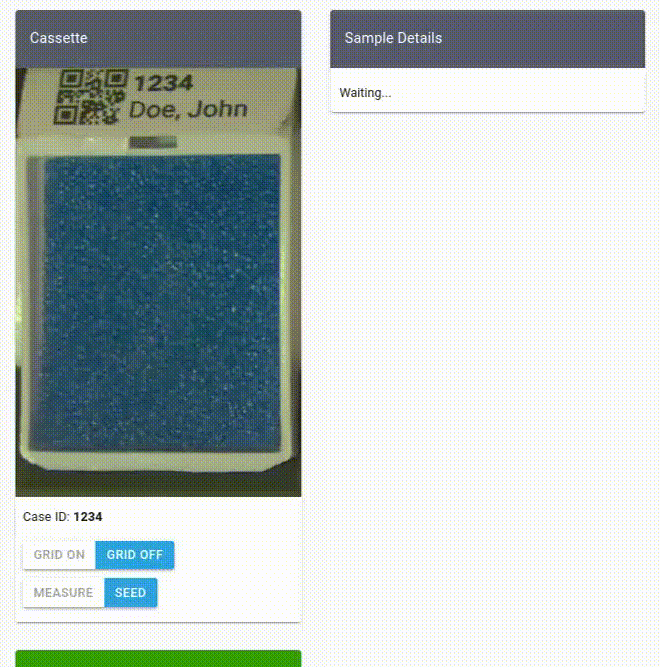

In [5]:
img = Image.open(detection_example_gif)

# first, grab one of the frames containing the tissue sample for later testing
img.seek(45)
test = img.copy()

# grab the first frame contaning only the slide tray for background color reference
img.seek(0)
display.display(img)

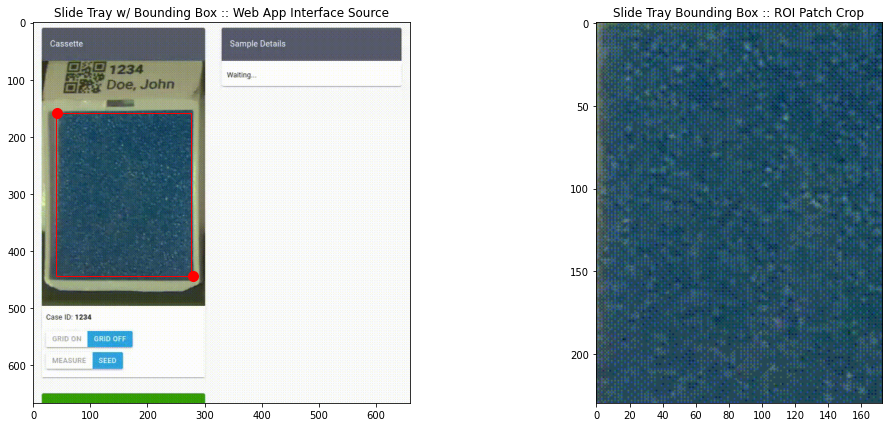

In [6]:
fig,axs = mp.subplots(1,2, figsize=(17,7))

axs[0].imshow(img)

# draw a bbox around the area of interest
axs[0].scatter( *top_left, s=100, color='red')
axs[0].scatter(*bot_right, s=100, color='red')

slide_patch = patches.Rectangle([40,158], bot_right[0] - top_left[0], bot_right[1] - top_left[1], 
                                linewidth=1, edgecolor='red', facecolor='none')
axs[0].add_patch(slide_patch)
axs[0].set_title('Slide Tray w/ Bounding Box :: Web App Interface Source')

# the `border` argument is a tuple containing (left, top, right, bottom) axis ordering
slide_crop = ImageOps.crop(img, border=(*top_left, *reversed(bot_right)))

axs[1].imshow(slide_crop)
axs[1].set_title('Slide Tray Bounding Box :: ROI Patch Crop')
mp.show()

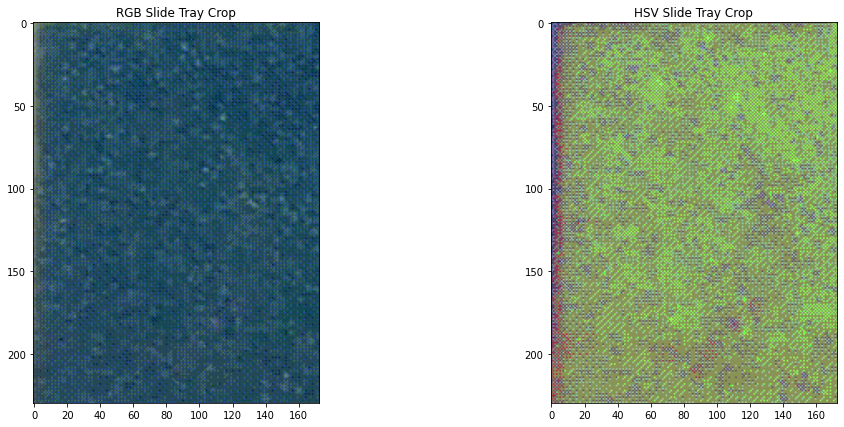

In [7]:
rgb = np.asarray(slide_crop.convert('RGB'))
hsv = np.asarray(slide_crop.convert('HSV'))

fig,axs = mp.subplots(1,2, figsize=(17,7))
axs[0].imshow(rgb)
axs[0].set_title('RGB Slide Tray Crop')
axs[1].imshow(hsv)
axs[1].set_title('HSV Slide Tray Crop')

mp.show()

/usr/local/lib/python3.9/site-packages/skimage/_shared/utils.py:293: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


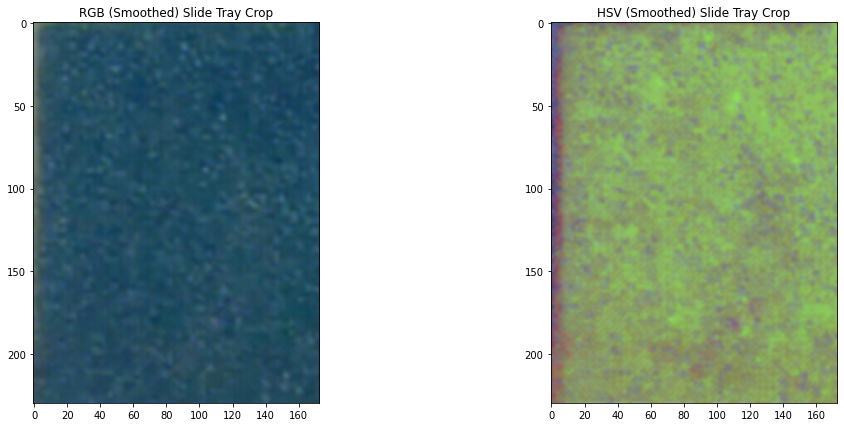

In [8]:
blur_rgb = skimage.filters.gaussian(rgb, sigma=1.)
blur_hsv = skimage.filters.gaussian(hsv, sigma=1.)

fig,axs = mp.subplots(1,2, figsize=(17,7))
axs[0].imshow(blur_rgb)
axs[0].set_title('RGB (Smoothed) Slide Tray Crop')
axs[1].imshow(blur_hsv)
axs[1].set_title('HSV (Smoothed) Slide Tray Crop')

mp.show()

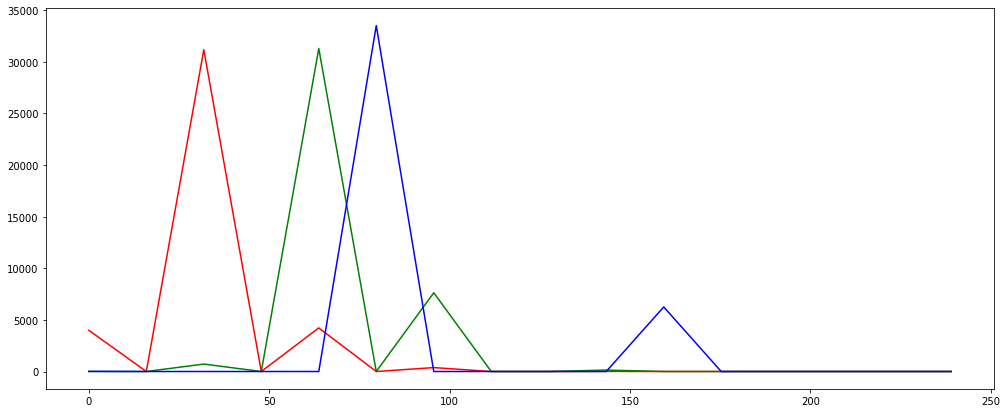

In [9]:
fig,ax = mp.subplots(1,1, figsize=(17,7))
r = rgb[...,0].reshape(-1)
g = rgb[...,1].reshape(-1)
b = rgb[...,2].reshape(-1)

bins = 16

r_hist, r_bins = np.histogram(r, bins=bins, range=(0, 255))
mp.plot(r_bins[0:-1], r_hist, color='r')
g_hist, g_bins = np.histogram(g, bins=bins, range=(0, 255))
mp.plot(g_bins[0:-1], g_hist, color='g')
b_hist, b_bins = np.histogram(b, bins=bins, range=(0, 255))
mp.plot(b_bins[0:-1], b_hist, color='b')

mp.show()

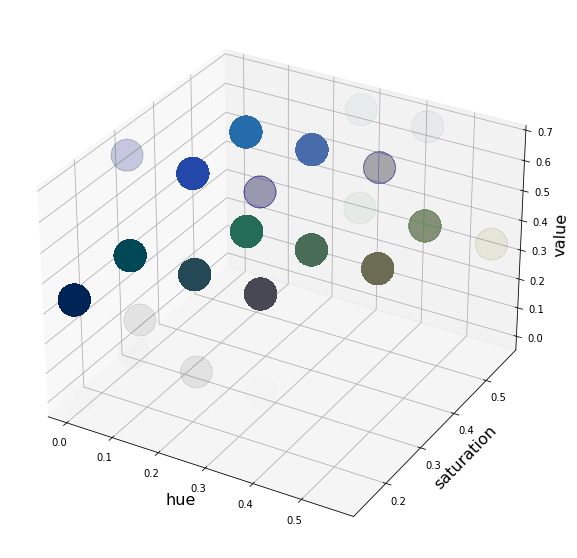

In [10]:
fig = mp.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

r,g,b = rgb[...,0], rgb[...,1], rgb[...,2]
h,s,v = hsv[...,0], hsv[...,1], hsv[...,2]

facecolors = rgb.reshape(-1,3) / 255.

r_scaled = r / 255.
g_scaled = g / 255.
b_scaled = b / 255.
ax.scatter(r_scaled.flatten(), g_scaled.flatten(), b_scaled.flatten(), facecolors=facecolors, s=2**10, alpha=7e-3)
ax.set_xlabel('hue', size=2**4)
ax.set_ylabel('saturation', size=2**4)
ax.set_zlabel('value', size=2**4)
mp.show()

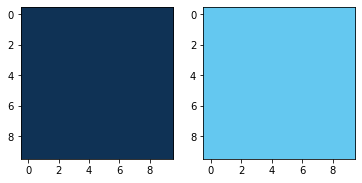

In [11]:
lower, upper = [15,50,85], [100,200,240]

fig,axs = mp.subplots(1,2)
axs[0].imshow(np.full((10, 10, 3), lower, dtype=np.uint8) / 255.0)
axs[1].imshow(np.full((10, 10, 3), upper, dtype=np.uint8) / 255.0)

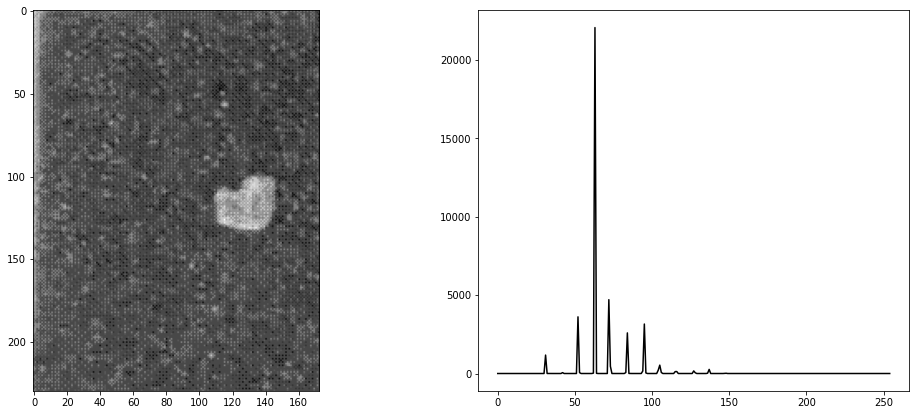

In [12]:
test_crop = ImageOps.crop(test, border=(*top_left, *reversed(bot_right))).convert('L')
test_arr = np.asarray(test_crop).reshape(-1,1)

fig,axs = mp.subplots(1,2, figsize=(17,7))
axs[0].imshow(test_crop, cmap='gray')
hist, bins = np.histogram(test_arr, bins=255, range=(0, 255))
axs[1].plot(bins[0:-1], hist, color='black')

mp.show()

In [13]:
threshold = 105

In [14]:
def image_itr(img):
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            bar.update(1)
            yield img[row,col]

 69%|██████▊   | 27300/39790 [00:00<00:00, 272999.61it/s]

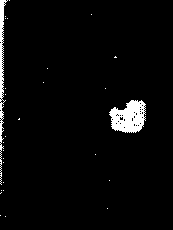

In [15]:
# create mask based on the grayscale threshold
test_crop = ImageOps.crop(test, border=(*top_left, *reversed(bot_right))).convert('L')
test_arr = np.asarray(test_crop)

buffer  = np.zeros(test_arr.shape[:2], np.uint8)

bar = tqdm.tqdm(total=np.prod(buffer.shape))
for i in range(buffer.shape[0]):
    for j in range(buffer.shape[1]):
        bar.update(1)
        if threshold <= test_arr[i,j]:  buffer[i,j] = 255
            
display.display(Image.fromarray(buffer))

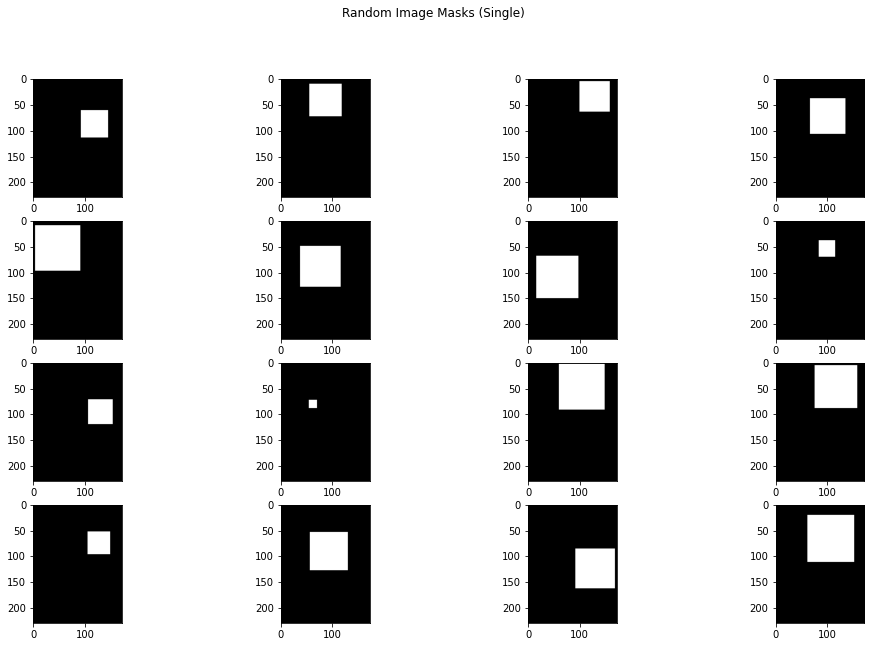

In [16]:
def random_mask(input_shape):
    buffer = np.zeros(input_shape[:2])
    k = np.random.randint(16,96)
    i = np.random.randint(0,buffer.shape[1] - k)
    j = np.random.randint(0,buffer.shape[1] - k)
    buffer[i:i+k,j:j+k] = 255
    return buffer
    
fig,axs = mp.subplots(4,4,figsize=(17,10))
fig.suptitle('Random Image Masks (Single)')
for i in range(4):
    for j in range(4):
        axs[i,j].imshow(Image.fromarray(random_mask(rgb.shape)))

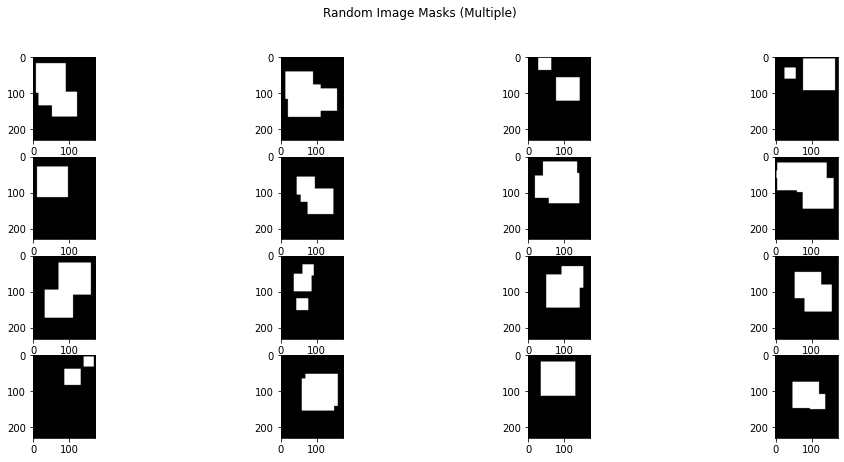

In [17]:
def random_masks(input_shape, n_masks=1):
    buffer = np.zeros(input_shape[:2])
    for _ in range(n_masks):
        k = np.random.randint(16,96)
        i = np.random.randint(0,buffer.shape[1] - k)
        j = np.random.randint(0,buffer.shape[1] - k)
        buffer[i:i+k,j:j+k] = 255
    return buffer
    
fig,axs = mp.subplots(4,4, figsize=(17,7))
fig.suptitle('Random Image Masks (Multiple)')
for i in range(4):
    for j in range(4):
        mask = random_masks(rgb.shape, n_masks=np.random.randint(2,5))
        axs[i,j].imshow(Image.fromarray(mask))

___

### Metric Example: Dice Coefficient

In [18]:
dice = lambda true,pred,cls=255:np.sum(pred[true == cls]) * 2. / (np.sum(true) + np.sum(pred))

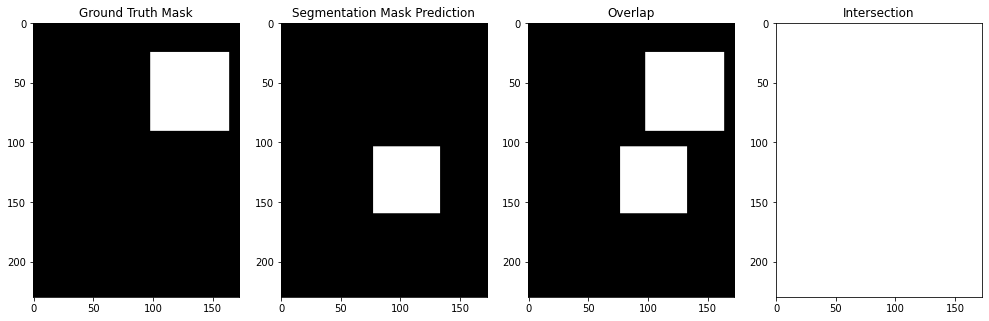

Dice Score :: 0.0000




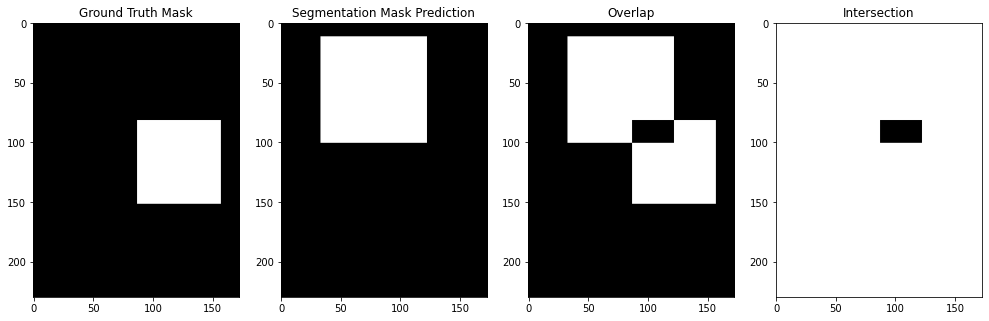

Dice Score :: 0.1037




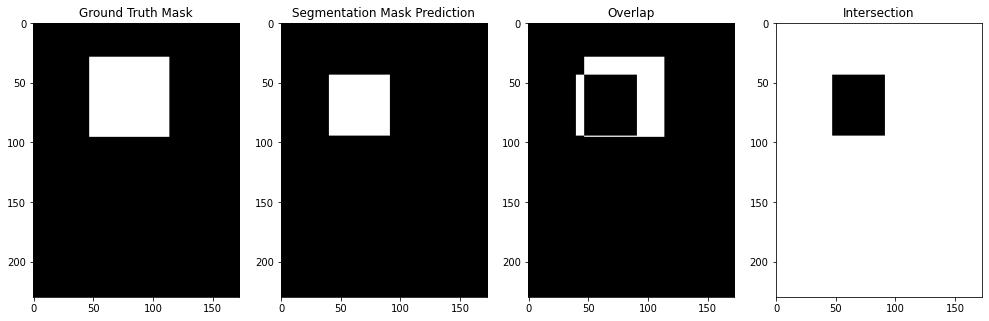

Dice Score :: 0.6330




100%|██████████| 39790/39790 [00:19<00:00, 272999.61it/s]

In [21]:
def random_masks(input_shape, n_masks=1):
    outputs = []
    for _ in range(n_masks):
        buffer = np.zeros(input_shape[:2])
        k = np.random.randint(16,96)
        i = np.random.randint(0,buffer.shape[1] - k)
        j = np.random.randint(0,buffer.shape[1] - k)
        buffer[i:i+k,j:j+k] = 255
        outputs.append(buffer)
    return outputs

# plot three examples of comparing a ground truth segmentation with a predicted mask
for _ in range(3):
    fig,axs = mp.subplots(1,4,figsize=(17,8))
    mask_1, mask_2 = random_masks(rgb.shape, n_masks=2)
    xor = np.logical_xor(mask_1, mask_2)
    nand=~np.logical_and(mask_1, mask_2)

    axs[0].imshow(Image.fromarray(mask_1))
    axs[0].set_title('Ground Truth Mask')
    axs[1].imshow(Image.fromarray(mask_2))
    axs[1].set_title('Segmentation Mask Prediction')

    axs[2].imshow(Image.fromarray(xor))
    axs[2].set_title('Overlap')
    axs[3].imshow(Image.fromarray(nand))
    axs[3].set_title('Intersection')

    mp.show()
    print('Dice Score :: {:.4f}\n\n'.format(dice(mask_1, mask_2)))